In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd

c:\Users\jaesc2\GitHub\skforecast


# Test bike sharing

In [2]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import (
    set_dark_theme,
    plot_residuals,
    plot_prediction_distribution,
    plot_prediction_intervals
)
from pprint import pprint

# Modelling and Forecasting
# ==============================================================================
from sklearn.pipeline import make_pipeline
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning import create_and_compile_model
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster_multiseries
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [3]:
# Data download
# ==============================================================================
data = fetch_dataset(name='bike_sharing', raw=False)
data = data[['users', 'temp', 'hum', 'windspeed', 'holiday']]
data = data.loc['2011-04-01 00:00:00':'2012-10-20 23:00:00', :].copy()
data.head(3)

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 11)


,users,temp,hum,windspeed,holiday
date_time,,,,,
2011-04-01 00:00:00,6.0,10.66,100.0,11.0014,0.0
2011-04-01 01:00:00,4.0,10.66,100.0,11.0014,0.0
2011-04-01 02:00:00,7.0,10.66,93.0,12.9980,0.0


In [4]:
# Calendar features
# ==============================================================================
features_to_extract = [
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables           = 'index',
    features_to_extract = features_to_extract,
    drop_original       = False,
)

# Cyclical encoding of calendar features
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 7,
    "hour": 24,
}
cyclical_encoder = CyclicalFeatures(
                       variables     = features_to_encode,
                       max_values    = max_values,
                       drop_original = True
                   )

exog_transformer = make_pipeline(
                       calendar_transformer,
                       cyclical_encoder
                   )

data = exog_transformer.fit_transform(data)
exog_features = data.columns.difference(['users']).tolist()
data.head(3)

,users,temp,hum,windspeed,holiday,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
date_time,,,,,,,,,,,,,
2011-04-01 00:00:00,6.0,10.66,100.0,11.0014,0.0,0.866025,-0.5,1.0,6.123234e-17,-0.433884,-0.900969,0.000000,1.000000
2011-04-01 01:00:00,4.0,10.66,100.0,11.0014,0.0,0.866025,-0.5,1.0,6.123234e-17,-0.433884,-0.900969,0.258819,0.965926
2011-04-01 02:00:00,7.0,10.66,93.0,12.9980,0.0,0.866025,-0.5,1.0,6.123234e-17,-0.433884,-0.900969,0.500000,0.866025


In [5]:
# Split train-validation-test
# ==============================================================================
end_train = '2012-06-30 23:59:00'
end_validation = '2012-10-01 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validation : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-04-01 00:00:00 --- 2012-06-30 23:00:00  (n=10968)
Dates validation : 2012-07-01 00:00:00 --- 2012-10-01 23:00:00  (n=2232)
Dates test       : 2012-10-02 00:00:00 --- 2012-10-20 23:00:00  (n=456)


In [6]:
# Advance usage of `create_and_compile_model`
# ==============================================================================    
series = ['users']
levels = ['users']
lags = 72

model = create_and_compile_model(
    series                  = data[series],  # DataFrame with all series (predictors)
    levels                  = levels, 
    lags                    = lags, 
    steps                   = 36, 
    exog                    = data[exog_features],    # Exogenous variables
    recurrent_layer         = "LSTM",
    recurrent_units         = [128, 64],
    recurrent_layers_kwargs = {"activation": "tanh"},
    dense_units             = [64, 32],
    compile_kwargs          = {'optimizer': 'adam', 'loss': 'mse'},
    model_name              = "MultiSeries-Multi-Step-Exog"
)

model.summary()

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



Model: "MultiSeries-Multi-Step-Exog"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ series_input        │ (None, 72, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 72, 128)   │     66,560 │ series_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     49,408 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 36, 64)    │          0 │ lstm_2[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exog_input          │ (None, 36, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_exog         │ (None, 36, 76)    │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ exog_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_td_1          │ (None, 36, 64)    │      4,928 │ concat_exog[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_td_2          │ (None, 36, 32)    │      2,080 │ dense_td_1[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense_td_la… │ (None, 36, 1)     │         33 │ dense_td_2[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 123,009 (480.50 KB)

 Trainable params: 123,009 (480.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    lags=lags, 
    transformer_series=MinMaxScaler(),
    transformer_exog=MinMaxScaler(),
    fit_kwargs={
        "epochs": 100, 
        "batch_size": 128, 
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val[series],  # Validation data for model training.
        "exog_val": data_val[exog_features]  # Validation data for exogenous variables
    },
)

# Fit forecaster with exogenous variables
# ==============================================================================
forecaster.fit(series=data_train[series], exog=data_train[exog_features])

c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)
c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 29s 273ms/step - loss: 0.0488 - val_loss: 0.0351 - learning_rate: 0.0010
Epoch 2/100


c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 324ms/step - loss: 0.0127 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 195ms/step - loss: 0.0100 - val_loss: 0.0250 - learning_rate: 0.0010
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - loss: 0.0082 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - loss: 0.0070 - val_loss: 0.0170 - learning_rate: 0.0010
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - loss: 0.0063 - val_loss: 0.0203 - learning_rate: 0.0010
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - loss: 0.0056 - val_loss: 0.0214 - learning_rate: 0.0010
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - loss: 0.0048 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - loss: 0.0040 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - loss: 0.0036 - val_loss: 0.0155 - learning_rate: 0.0010
Epo

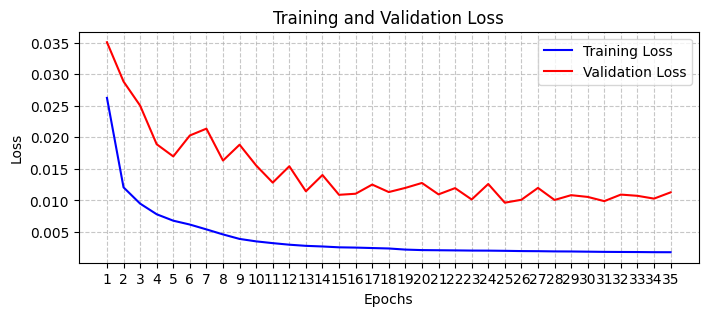

In [9]:
# Training and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
_ = forecaster.plot_history(ax=ax)

In [10]:
# Backtesting with test data and exogenous variables
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

metrics_exog, predictions_exog = backtesting_forecaster_multiseries(
    forecaster        = forecaster,
    series            = data[series],
    exog              = data[exog_features],
    cv                = cv,
    levels            = forecaster.levels,
    metric            = "mean_absolute_error",
    suppress_warnings = True,
    verbose           = False,
    n_jobs            = "auto"
)

c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - loss: 0.0028 - val_loss: 0.0048 - learning_rate: 1.2500e-04
Epoch 2/100
  1/103 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - loss: 0.0029

c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - loss: 0.0025 - val_loss: 0.0046 - learning_rate: 1.2500e-04
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - loss: 0.0024 - val_loss: 0.0043 - learning_rate: 1.2500e-04
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - loss: 0.0023 - val_loss: 0.0040 - learning_rate: 1.2500e-04
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - loss: 0.0023 - val_loss: 0.0039 - learning_rate: 1.2500e-04
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - loss: 0.0023 - val_loss: 0.0039 - learning_rate: 1.2500e-04
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - loss: 0.0023 - val_loss: 0.0038 - learning_rate: 1.2500e-04
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - loss: 0.0022 - val_loss: 0.0038 - learning_rate: 1.2500e-04
Epoch 9/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - loss: 0.0023 - val_loss: 0.0037 - learning_rate: 1.2500e-04
Epoch 10/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - loss: 0.0

  0%|          | 0/13 [00:00<?, ?it/s]

In [11]:
# With exog XGboost, MAE = 49
metrics_exog

,levels,mean_absolute_error
0,users,49.364107


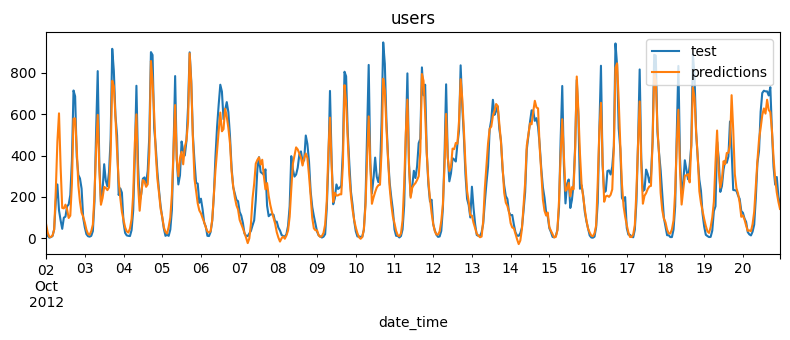

In [12]:
# Plot all the predicted variables as rows in the plot
# ==============================================================================
fig, ax = plt.subplots(len(levels), 1, figsize=(8, 3.5), sharex=True)
for i, level in enumerate(levels):
    data_test[level].plot(ax=ax, label="test")
    predictions_exog.loc[predictions_exog["level"] == level, "pred"].plot(ax=ax, label="predictions")
    ax.set_title(level)
    ax.legend()

plt.tight_layout()
plt.show()

### no exog

In [13]:
# Advance usage of `create_and_compile_model`
# ==============================================================================    
series = ['users']
levels = ['users']
lags = 72

model = create_and_compile_model(
    series                  = data[series],  # DataFrame with all series (predictors)
    levels                  = levels, 
    lags                    = lags, 
    steps                   = 36, 
    # exog                    = data[exog_features],    # Exogenous variables
    recurrent_layer         = "LSTM",
    recurrent_units         = [128, 64],
    recurrent_layers_kwargs = {"activation": "tanh"},
    dense_units             = [64, 32],
    compile_kwargs          = {'optimizer': 'adam', 'loss': 'mse'},
    model_name              = "MultiSeries-Multi-Step-Exog"
)

model.summary()

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



Model: "MultiSeries-Multi-Step-Exog"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 72, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 72, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_td_layer (Dense)   │ (None, 36)             │         1,188 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 36, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,396 (482.02 KB)

 Trainable params: 123,396 (482.02 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    lags=lags, 
    transformer_series=MinMaxScaler(),
    transformer_exog=MinMaxScaler(),
    fit_kwargs={
        "epochs": 100, 
        "batch_size": 128, 
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val[series],  # Validation data for model training.
    },
)

# Fit forecaster with exogenous variables
# ==============================================================================
forecaster.fit(series=data_train[series])

Epoch 1/100


c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)
c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.0481 - val_loss: 0.0382 - learning_rate: 0.0010
Epoch 2/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - loss: 0.0187

c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 0.0164 - val_loss: 0.0265 - learning_rate: 0.0010
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0128 - val_loss: 0.0238 - learning_rate: 0.0010
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.0120 - val_loss: 0.0217 - learning_rate: 0.0010
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 0.0115 - val_loss: 0.0215 - learning_rate: 0.0010
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0111 - val_loss: 0.0221 - learning_rate: 0.0010
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 0.0108 - val_loss: 0.0203 - learning_rate: 0.0010
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 0.0104 - val_loss: 0.0193 - learning_rate: 0.0010
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0102 - val_loss: 0.0178 - learning_rate: 0.0010
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 0.0099 - val_loss: 0.0172 - learning_rate: 0.0010
Epoch 

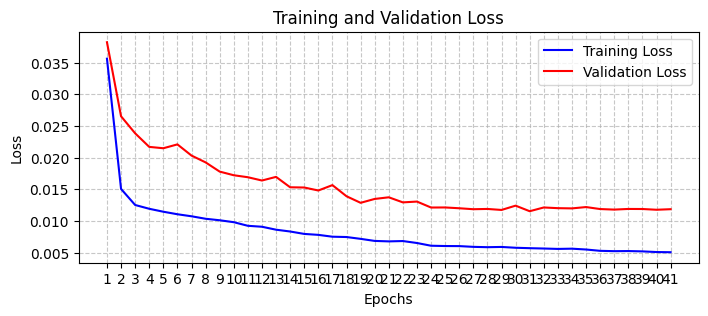

In [15]:
# Training and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
_ = forecaster.plot_history(ax=ax)

In [16]:
# Backtesting with test data and exogenous variables
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

metrics_no_exog_old_func, predictions_no_exog_old_func = backtesting_forecaster_multiseries(
    forecaster        = forecaster,
    series            = data[series],
    # exog              = data[exog_features],
    cv                = cv,
    levels            = forecaster.levels,
    metric            = "mean_absolute_error",
    suppress_warnings = True,
    verbose           = False
)

c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - loss: 0.0062 - val_loss: 0.0099 - learning_rate: 1.2500e-04
Epoch 2/100
  1/103 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - loss: 0.0069

c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 0.0061 - val_loss: 0.0094 - learning_rate: 1.2500e-04
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - loss: 0.0061 - val_loss: 0.0092 - learning_rate: 1.2500e-04
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 0.0059 - val_loss: 0.0090 - learning_rate: 1.2500e-04
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - loss: 0.0060 - val_loss: 0.0089 - learning_rate: 1.2500e-04
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 0.0059 - val_loss: 0.0091 - learning_rate: 1.2500e-04
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 0.0059 - val_loss: 0.0088 - learning_rate: 1.2500e-04
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - loss: 0.0059 - val_loss: 0.0088 - learning_rate: 1.2500e-04
Epoch 9/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - loss: 0.0059 - val_loss: 0.0088 - learning_rate: 1.2500e-04
Epoch 10/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - loss: 0.0

  0%|          | 0/13 [00:00<?, ?it/s]

In [17]:
# With exog XGboost, MAE = 76
metrics_no_exog_old_func

,levels,mean_absolute_error
0,users,69.331473


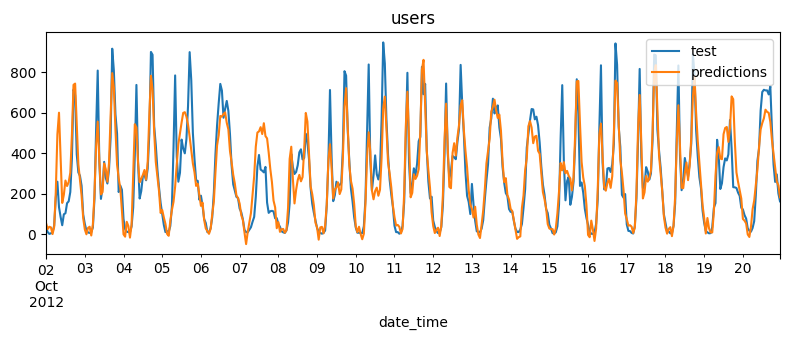

In [18]:
# Plot all the predicted variables as rows in the plot
# ==============================================================================
fig, ax = plt.subplots(len(levels), 1, figsize=(8, 3.5), sharex=True)
for i, level in enumerate(levels):
    data_test[level].plot(ax=ax, label="test")
    predictions_no_exog_old_func.loc[predictions_no_exog_old_func["level"] == level, "pred"].plot(ax=ax, label="predictions")
    ax.set_title(level)
    ax.legend()

plt.tight_layout()
plt.show()

### No exog but with compile_exog

In [19]:
# Advance usage of `create_and_compile_model`
# ============================================================================== 
from skforecast.deep_learning.utils import _create_and_compile_model_exog
   
series = ['users']
levels = ['users']
lags = 72

model = _create_and_compile_model_exog(
    series                  = data[series],  # DataFrame with all series (predictors)
    levels                  = levels, 
    lags                    = lags, 
    steps                   = 36, 
    # exog                    = data[exog_features],    # Exogenous variables
    recurrent_layer         = "LSTM",
    recurrent_units         = [128, 64],
    recurrent_layers_kwargs = {"activation": "tanh"},
    dense_units             = [64, 32],
    compile_kwargs          = {'optimizer': 'adam', 'loss': 'mse'},
    model_name              = "MultiSeries-Multi-Step-Exog"
)

model.summary()

Model: "MultiSeries-Multi-Step-Exog"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 72, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 72, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 36, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_td_1 (TimeDistributed)    │ (None, 36, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_td_2 (TimeDistributed)    │ (None, 36, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_td_layer           │ (None, 36, 1)          │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,241 (477.50 KB)

 Trainable params: 122,241 (477.50 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    lags=lags, 
    transformer_series=MinMaxScaler(),
    transformer_exog=MinMaxScaler(),
    fit_kwargs={
        "epochs": 100, 
        "batch_size": 128, 
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val[series],  # Validation data for model training.
    },
)

# Fit forecaster with exogenous variables
# ==============================================================================
forecaster.fit(series=data_train[series])

c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)
c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step - loss: 0.0353 - val_loss: 0.0593 - learning_rate: 0.0010
Epoch 2/100


c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - loss: 0.0282 - val_loss: 0.0587 - learning_rate: 0.0010
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - loss: 0.0280 - val_loss: 0.0582 - learning_rate: 0.0010
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - loss: 0.0280 - val_loss: 0.0591 - learning_rate: 0.0010
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - loss: 0.0280 - val_loss: 0.0586 - learning_rate: 0.0010
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - loss: 0.0278 - val_loss: 0.0591 - learning_rate: 0.0010
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0276
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - loss: 0.0276 - val_loss: 0.0581 - learning_rate: 0.0010
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - loss: 0.0275 - val_loss: 0.0585 - learning_rate: 5.0000e-04
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - loss: 0.0277 - val_loss: 0.0579 - le

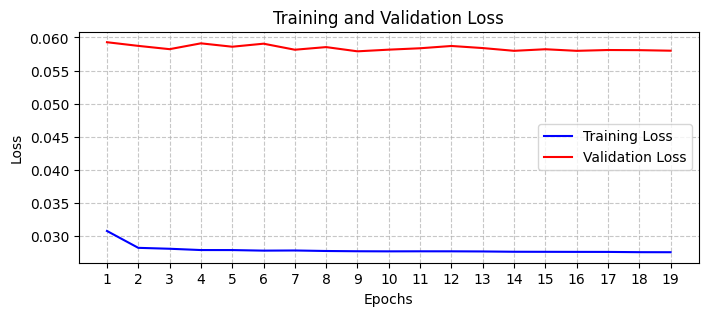

In [21]:
# Training and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
_ = forecaster.plot_history(ax=ax)

In [ ]:
# Backtesting with test data and exogenous variables
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

metrics_no_exog_new_func, predictions_no_exog_new_func = backtesting_forecaster_multiseries(
    forecaster        = forecaster,
    series            = data[series],
    # exog              = data[exog_features],
    cv                = cv,
    levels            = forecaster.levels,
    metric            = "mean_absolute_error",
    suppress_warnings = True,
    verbose           = False
)

Epoch 1/100


c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


103/103 ━━━━━━━━━━━━━━━━━━━━ 23s 197ms/step - loss: 0.0315 - val_loss: 0.0555 - learning_rate: 1.2500e-04
Epoch 2/100
  1/103 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - loss: 0.0319

c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - loss: 0.0311 - val_loss: 0.0554 - learning_rate: 1.2500e-04
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - loss: 0.0312 - val_loss: 0.0554 - learning_rate: 1.2500e-04
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - loss: 0.0313 - val_loss: 0.0554 - learning_rate: 1.2500e-04
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0314
Epoch 5: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - loss: 0.0314 - val_loss: 0.0555 - learning_rate: 1.2500e-04
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - loss: 0.0314 - val_loss: 0.0554 - learning_rate: 6.2500e-05
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - loss: 0.0312 - val_loss: 0.0555 - learning_rate: 6.2500e-05
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - loss: 0.0310 - val_loss: 0.0554 - learning_rate: 6.2500e-05
Epoch 9/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/ste

  0%|          | 0/12 [00:00<?, ?it/s]

In [23]:
# With exog XGboost, MAE = 76
metrics_no_exog_new_func

,levels,mean_absolute_error
0,users,188.892825


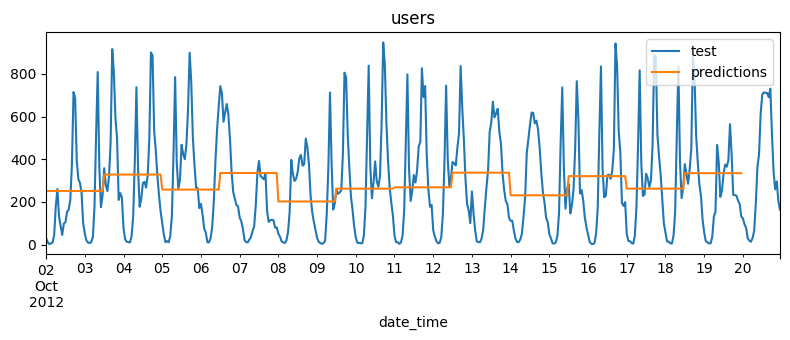

In [24]:
# Plot all the predicted variables as rows in the plot
# ==============================================================================
fig, ax = plt.subplots(len(levels), 1, figsize=(8, 3.5), sharex=True)
for i, level in enumerate(levels):
    data_test[level].plot(ax=ax, label="test")
    predictions_no_exog_new_func.loc[predictions_no_exog_new_func["level"] == level, "pred"].plot(ax=ax, label="predictions")
    ax.set_title(level)
    ax.legend()

plt.tight_layout()
plt.show()

In [32]:
pd.DataFrame(
    {
        "exog": metrics_exog["mean_absolute_error"],
        "no_exog_old_func": metrics_no_exog_old_func["mean_absolute_error"],
        "no_exog_new_func": metrics_no_exog_new_func["mean_absolute_error"]
    },
    index=metrics_exog.index
).round(2)

,exog,no_exog_old_func,no_exog_new_func
0,49.36,69.33,188.89


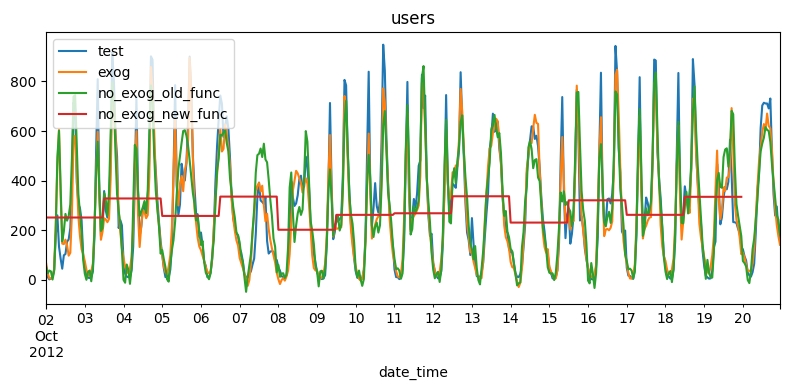

In [34]:
# Plot all the predicted variables as rows in the plot
# ==============================================================================
fig, ax = plt.subplots(len(levels), 1, figsize=(8, 4), sharex=True)
for i, level in enumerate(levels):
    data_test[level].plot(ax=ax, label="test")
    predictions_exog.loc[predictions_exog["level"] == level, "pred"].plot(ax=ax, label="exog")
    predictions_no_exog_old_func.loc[predictions_no_exog_old_func["level"] == level, "pred"].plot(ax=ax, label="no_exog_old_func")
    predictions_no_exog_new_func.loc[predictions_no_exog_new_func["level"] == level, "pred"].plot(ax=ax, label="no_exog_new_func")
    ax.set_title(level)
    ax.legend()

plt.tight_layout()
plt.show()